# APIM ❤️ OpenAI

## Semantic Caching lab
![flow](../../images/semantic-caching.gif)

Playground to try the [semantic caching policy](https://learn.microsoft.com/azure/api-management/azure-openai-semantic-cache-lookup-policy). 

The azure-openai-semantic-cache-lookup policy conducts a cache lookup of responses on Azure OpenAI Chat Completion API and Completion API requests from a pre-configured external cache. It operates by comparing the vector proximity of the prompt to prior requests and using a specific similarity score threshold. Caching responses helps reduce bandwidth and processing demands on the backend Azure OpenAI API, thus reducing latency perceived by API consumers.  
👉🏽 Update: The [Bicep file](main.bicep) was updated to use the new [Azure Managed Redis](https://azure.microsoft.com/en-us/products/managed-redis/) for improved cost efficiency.

[View policy configuration](policy.xml)

### Result
![result](result.png)

### Prerequisites
- [Python 3.12 or later version](https://www.python.org/) installed
- [Pandas Library](https://pandas.pydata.org/) and matplotlib installed
- [Redis Cache Library](https://pypi.org/project/redis/) installed
- [VS Code](https://code.visualstudio.com/) installed with the [Jupyter notebook extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter) enabled
- [Azure CLI](https://learn.microsoft.com/cli/azure/install-azure-cli) installed
- [An Azure Subscription](https://azure.microsoft.com/free/) with Contributor permissions
- [Access granted to Azure OpenAI](https://aka.ms/oai/access) or just enable the mock service
- [Sign in to Azure with Azure CLI](https://learn.microsoft.com/cli/azure/authenticate-azure-cli-interactively)

<a id='0'></a>
### 0️⃣ Initialize notebook variables

- Resources will be suffixed by a unique string based on your subscription id.
- Adjust the location parameters according your preferences and on the [product availability by Azure region.](https://azure.microsoft.com/explore/global-infrastructure/products-by-region/?cdn=disable&products=cognitive-services,api-management) 
- Adjust the OpenAI model and version according the [availability by region.](https://learn.microsoft.com/azure/ai-services/openai/concepts/models) 

In [2]:
import os, sys, json
sys.path.insert(1, '../../shared')  # add the shared directory to the Python path
import utils

deployment_name = os.path.basename(os.path.dirname(globals()['__vsc_ipynb_file__']))
resource_group_name = f"techo-{deployment_name}" # change the name to match your naming style
resource_group_location = "uksouth"

apim_sku = 'Basicv2'

openai_resources = [ {"name": "openai1", "location": "uksouth"}]

openai_model_name = "gpt-4o-mini"
openai_model_version = "2024-07-18"
openai_model_sku = "GlobalStandard"
openai_model_capacity = 20
openai_deployment_name = "gpt-4o-mini"
openai_api_version = "2024-10-21"

embeddings_deployment_name = "text-embedding-ada-002"
embeddings_model_name = "text-embedding-ada-002"
embeddings_model_version = "2"
rediscache_name = "rediscache"
rediscache_sku = "Balanced_B0" # By default it uses the most cost efficient. Check the docs to choose the right SKU: https://learn.microsoft.com/en-us/azure/azure-cache-for-redis/managed-redis/managed-redis-overview#choosing-the-right-tier

utils.print_ok('Notebook initialized')

✅ Notebook initialized ⌚ 22:42:04.802417 


<a id='1'></a>
### 1️⃣ Verify the Azure CLI and the connected Azure subscription

The following commands ensure that you have the latest version of the Azure CLI and that the Azure CLI is connected to your Azure subscription.

In [3]:
output = utils.run("az account show", "Retrieved az account", "Failed to get the current az account")

if output.success and output.json_data:
    current_user = output.json_data['user']['name']
    tenant_id = output.json_data['tenantId']
    subscription_id = output.json_data['id']

    utils.print_info(f"Current user: {current_user}")
    utils.print_info(f"Tenant ID: {tenant_id}")
    utils.print_info(f"Subscription ID: {subscription_id}")

⚙️ Running: az account show 
✅ Retrieved az account ⌚ 22:42:08.815250 :1s]
👉🏽 Current user: inbox@massimocrippa.com
👉🏽 Tenant ID: 1de23963-6823-4ea6-9ac4-4cf69c102307
👉🏽 Subscription ID: b717ac47-f31b-41f9-adc2-579932e7e02e


<a id='2'></a>
### 2️⃣ Create deployment using 🦾 Bicep

This lab uses [Bicep](https://learn.microsoft.com/azure/azure-resource-manager/bicep/overview?tabs=bicep) to declarative define all the resources that will be deployed in the specified resource group. Change the parameters or the [main.bicep](main.bicep) directly to try different configurations.


In [14]:
# Create the resource group if doesn't exist
utils.create_resource_group(resource_group_name, resource_group_location)

# Define the Bicep parameters
bicep_parameters = {
    "$schema": "https://schema.management.azure.com/schemas/2019-04-01/deploymentParameters.json#",
    "contentVersion": "1.0.0.0",
    "parameters": {
        "apimSku": { "value": apim_sku },
        "openAIConfig": { "value": openai_resources },
        "openAIDeploymentName": { "value": openai_deployment_name },
        "openAIModelName": { "value": openai_model_name },
        "openAIModelVersion": { "value": openai_model_version },
        "openAIModelSKU": { "value": openai_model_sku },
        "openAIModelCapacity": { "value": openai_model_capacity },
        "openAIAPIVersion": { "value": openai_api_version },
        "embeddingsModelName": { "value": embeddings_model_name },
        "embeddingsModelVersion": { "value": embeddings_model_version },
        "redisCacheName": { "value": rediscache_name },
        "redisCacheSKU": { "value": rediscache_sku }
    }
}

# Write the parameters to the params.json file
with open('params.json', 'w') as bicep_parameters_file:
    bicep_parameters_file.write(json.dumps(bicep_parameters))

# Run the deployment
output = utils.run(f"az deployment group create --name {deployment_name} --resource-group {resource_group_name} --template-file main.bicep --parameters params.json",
    f"Deployment '{deployment_name}' succeeded", f"Deployment '{deployment_name}' failed")

⚙️ Running: az group show --name techo-semantic-caching 
👉🏽 Using existing resource group 'techo-semantic-caching'
⚙️ Running: az deployment group create --name semantic-caching --resource-group techo-semantic-caching --template-file main.bicep --parameters params.json 
✅ Deployment 'semantic-caching' succeeded ⌚ 22:24:16.633212 :16s]


<a id='3'></a>
### 3️⃣ Get the deployment outputs

Retrieve the required outputs from the Bicep deployment.

In [4]:
# Obtain all of the outputs from the deployment
output = utils.run(f"az deployment group show --name {deployment_name} -g {resource_group_name}", f"Retrieved deployment: {deployment_name}", f"Failed to retrieve deployment: {deployment_name}")

if output.success and output.json_data:
    apim_resource_gateway_url = utils.get_deployment_output(output, 'apimResourceGatewayURL', 'APIM API Gateway URL')
    apim_subscription_key = utils.get_deployment_output(output, 'apimSubscriptionKey', 'APIM Subscription Key (masked)', True)
    rediscache_host = utils.get_deployment_output(output, 'redisCacheHost', 'Redis Cache Host')
    rediscache_key = utils.get_deployment_output(output, 'redisCacheKey', 'Redis Cache Key (masked)', True)
    rediscache_port = int(utils.get_deployment_output(output, 'redisCachePort', 'Redis Cache Port'))


⚙️ Running: az deployment group show --name semantic-caching -g techo-semantic-caching 
✅ Retrieved deployment: semantic-caching ⌚ 22:42:12.986414 :2s]
👉🏽 APIM API Gateway URL: https://apim-zn6mf6z4vchxc.azure-api.net
👉🏽 APIM Subscription Key (masked): ****21cd
👉🏽 Redis Cache Host: rediscache-zn6mf6z4vchxc.uksouth.redis.azure.net
👉🏽 Redis Cache Key (masked): ****EHg=
👉🏽 Redis Cache Port: 10000


<a id='sdk'></a>
### 🧪 Make multiple calls using the Azure OpenAI Python SDK

The code below contains a list of questions that will be randomly selected and sent as prompts to the OpenAI API

In [5]:
from openai import AzureOpenAI
import time, random

runs = 20
sleep_time_ms = 10
questions = ["How to Brew the Perfect Cup of Coffee?",
             "What are the steps to Craft the Ideal Espresso?",
             "Tell me how to create the best steaming Java?",
             "Explain how to make a caffeinated brewed beverage?"]
api_runs = []  # Response Times for each run
client = AzureOpenAI(
    azure_endpoint = apim_resource_gateway_url,
    api_key = apim_subscription_key,
    api_version = openai_api_version
)

for i in range(runs):
    print(f"▶️ Run {i+1}/{runs}:")
    random_question = random.choice(questions)
    print("💬 ", random_question)

    start_time = time.time()
    response = client.chat.completions.create(
        model = openai_model_name,
        messages = [
            {"role": "system", "content": "You are a sarcastic, unhelpful assistant."},
            {"role": "user", "content": random_question}
        ])
    response_time = time.time() - start_time

    print(f"⌚ {response_time:.2f} seconds")

    # Uncomment to print the response
    #print(f"💬 {response.choices[0].message.content}\n")

    api_runs.append(response_time)
    time.sleep(sleep_time_ms/1000)

▶️ Run 1/20:
💬  Explain how to make a caffeinated brewed beverage?
⌚ 5.71 seconds
▶️ Run 2/20:
💬  Explain how to make a caffeinated brewed beverage?
⌚ 3.00 seconds
▶️ Run 3/20:
💬  How to Brew the Perfect Cup of Coffee?
⌚ 1.30 seconds
▶️ Run 4/20:
💬  How to Brew the Perfect Cup of Coffee?
⌚ 2.02 seconds
▶️ Run 5/20:
💬  What are the steps to Craft the Ideal Espresso?
⌚ 2.60 seconds
▶️ Run 6/20:
💬  Explain how to make a caffeinated brewed beverage?
⌚ 2.28 seconds
▶️ Run 7/20:
💬  Tell me how to create the best steaming Java?
⌚ 2.30 seconds
▶️ Run 8/20:
💬  Explain how to make a caffeinated brewed beverage?
⌚ 3.13 seconds
▶️ Run 9/20:
💬  What are the steps to Craft the Ideal Espresso?
⌚ 2.95 seconds
▶️ Run 10/20:
💬  Tell me how to create the best steaming Java?
⌚ 2.90 seconds
▶️ Run 11/20:
💬  Explain how to make a caffeinated brewed beverage?
⌚ 2.46 seconds
▶️ Run 12/20:
💬  What are the steps to Craft the Ideal Espresso?
⌚ 2.23 seconds
▶️ Run 13/20:
💬  Tell me how to create the best steaming

<a id='plot'></a>
### 🔍 Analyze Semantic Caching performance

The first request should take a longer time as it makes it all the way to the Azure OpenAI backend. The subsequent requests should be much quicker as they draw from the semantic cache. Note that making more than 20 requests may result in spikes similar to the first request. As we are using the cheapest, smallest Basic Redis cache (B0), the cache server will eventually return a 429, forcing API Management to make a longer request to the Azure OpenAI backend. This is expected as B0 is not intended for load scenarios.

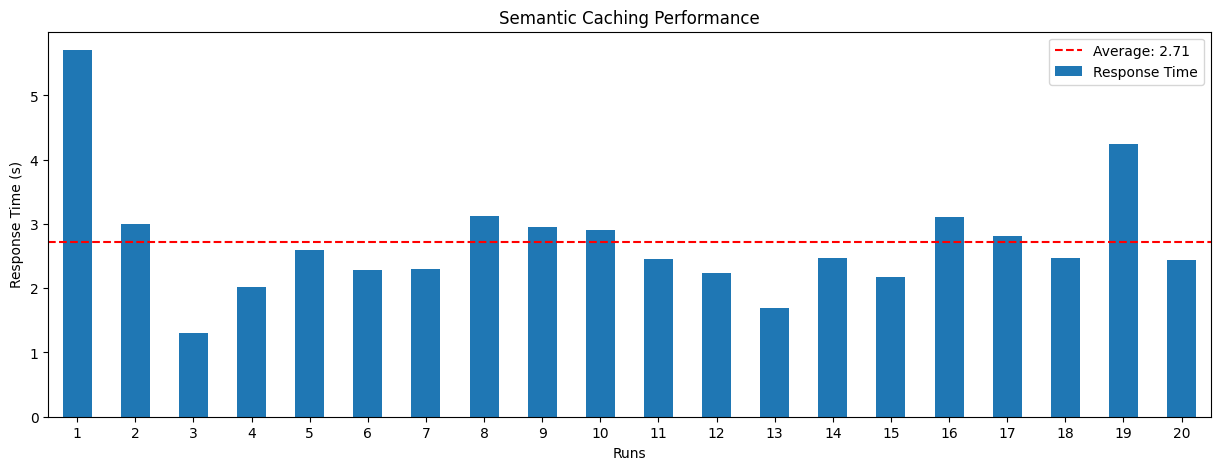

In [6]:
# plot the results
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [15, 5]
df = pd.DataFrame(api_runs, columns=['Response Time'])
df['Run'] = range(1, len(df) + 1)
df.plot(kind='bar', x='Run', y='Response Time', legend=False)
plt.title('Semantic Caching Performance')
plt.xlabel('Runs')
plt.ylabel('Response Time (s)')
plt.xticks(rotation=0)  # Set x-axis ticks to be the run numbers

average = df['Response Time'].mean()
plt.axhline(y=average, color='r', linestyle='--', label=f'Average: {average:.2f}')
plt.legend()

plt.show()

<a id='statistics'></a>
### 🔍 Show Redis Cache information

In [ ]:
# install required packages
pip install redis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import redis.asyncio as redis

async def get_redis_info():
    r = await redis.from_url(
        f"rediss://:{rediscache_key}@{rediscache_host}:{rediscache_port}"
    )

    info = await r.info()

    print("Redis Server Information:")
    print(f"Used Memory  : {info['used_memory_human']}")
    # Display the Redis info in a pandas DataFrame and plot it

    def convert_memory_to_bytes(memory_str):
        units = {"K": 1024, "M": 1024**2, "G": 1024**3}
        if memory_str[-1] in units:
            return float(memory_str[:-1]) * units[memory_str[-1]]
        return float(memory_str)

    redis_info = {
        'Metric': ['Cache Hits', 'Cache Misses', 'Evicted Keys', 'Expired Keys'],
        'Value': [info['keyspace_hits'], info['keyspace_misses'], info['evicted_keys'], info['expired_keys']]
    }

    df_redis_info = pd.DataFrame(redis_info)
    df_redis_info.plot(kind='barh', x='Metric', y='Value', legend=False)

    plt.title('Redis Server Information')
    plt.xlabel('Value')
    plt.ylabel('Metric')
    plt.show()

    await r.aclose()

await get_redis_info()

### 🗑️ Clean up resources

When you're finished with the lab, you should remove all your deployed resources from Azure to avoid extra charges and keep your Azure subscription uncluttered.
Use the [clean-up-resources notebook](clean-up-resources.ipynb) for that.